In [3]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import sys
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from healthrex_ml.evaluators import BinaryEvaluator
from tqdm import tqdm

In [4]:
from ngboost import NGBRegressor
from functions.trainers import NGBoostTrainer, LightGBMTrainer

In [5]:
trainer = NGBoostTrainer(working_dir="/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts")

In [6]:
tasks = ['label_NA', 'label_K', 'label_CR', 'label_CA', 'label_ALB']

In [ ]:
for task in tasks:
    trainer(task)

In [7]:
working_dir = "/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts"
y_hats_NA = pd.read_csv(
            os.path.join(working_dir, 'label_NA_yhats.csv'))
y_hats_K = pd.read_csv(
            os.path.join(working_dir, 'label_K_yhats.csv'))
y_hats_CR = pd.read_csv(
            os.path.join(working_dir, 'label_CR_yhats.csv'))
y_hats_CA = pd.read_csv(
            os.path.join(working_dir, 'label_CA_yhats.csv'))
y_hats_ALB = pd.read_csv(
            os.path.join(working_dir, 'label_ALB_yhats.csv'))

In [8]:
y_test = pd.read_csv(
    os.path.join(working_dir, "test_labels.csv"))

In [10]:
def add_probs(df, test, delta_p):
    last_test = "label_last_" + test
    delta = delta_p * y_test[last_test]
    df["upper_z"] = (y_test[last_test] + delta - df["dist_mean"]) / np.sqrt(df["dist_var"])
    df["lower_z"] = (y_test[last_test] - delta - df["dist_mean"]) / np.sqrt(df["dist_var"])
    df["upper_p"] = 1 - norm.cdf(df["upper_z"])
    df["lower_p"] = norm.cdf(df["lower_z"])
    df["stable_p"] = 1 - df["upper_p"] - df["lower_p"]
    key_idx = ["observation_id", "dist_mean", "dist_var", "upper_p", "lower_p", "stable_p"]
    return df[key_idx]

In [13]:
py_hats_NA = add_probs(y_hats_NA, "NA", 0.1)
py_hats_K = add_probs(y_hats_K, "K", 0.1)
py_hats_CR = add_probs(y_hats_CR, "CR", 0.1)
py_hats_CA = add_probs(y_hats_CA, "CA", 0.1)
py_hats_ALB = add_probs(y_hats_ALB, "ALB", 0.1)

In [24]:
def add_truth_label(test, delta_p):
    label = "label_" + test
    last_test = "label_last_" + test
    delta = delta_p * y_test[last_test]
    stable = "label_" + test + "_stable"
    lower = "label_" + test + "_lower"
    higher = "label_" + test + "_higher"
    y_test[lower] = (y_test[last_test] - delta > y_test[label])
    y_test[higher] = (y_test[label] > y_test[last_test] + delta)
    y_test[stable] = (~y_test[lower]) & (~y_test[higher])

In [25]:
tests = ["NA", "K", "CR", "CA", "ALB"]
for test in tests:
    add_truth_label(test, 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:06<00:00, 85.32s/it]


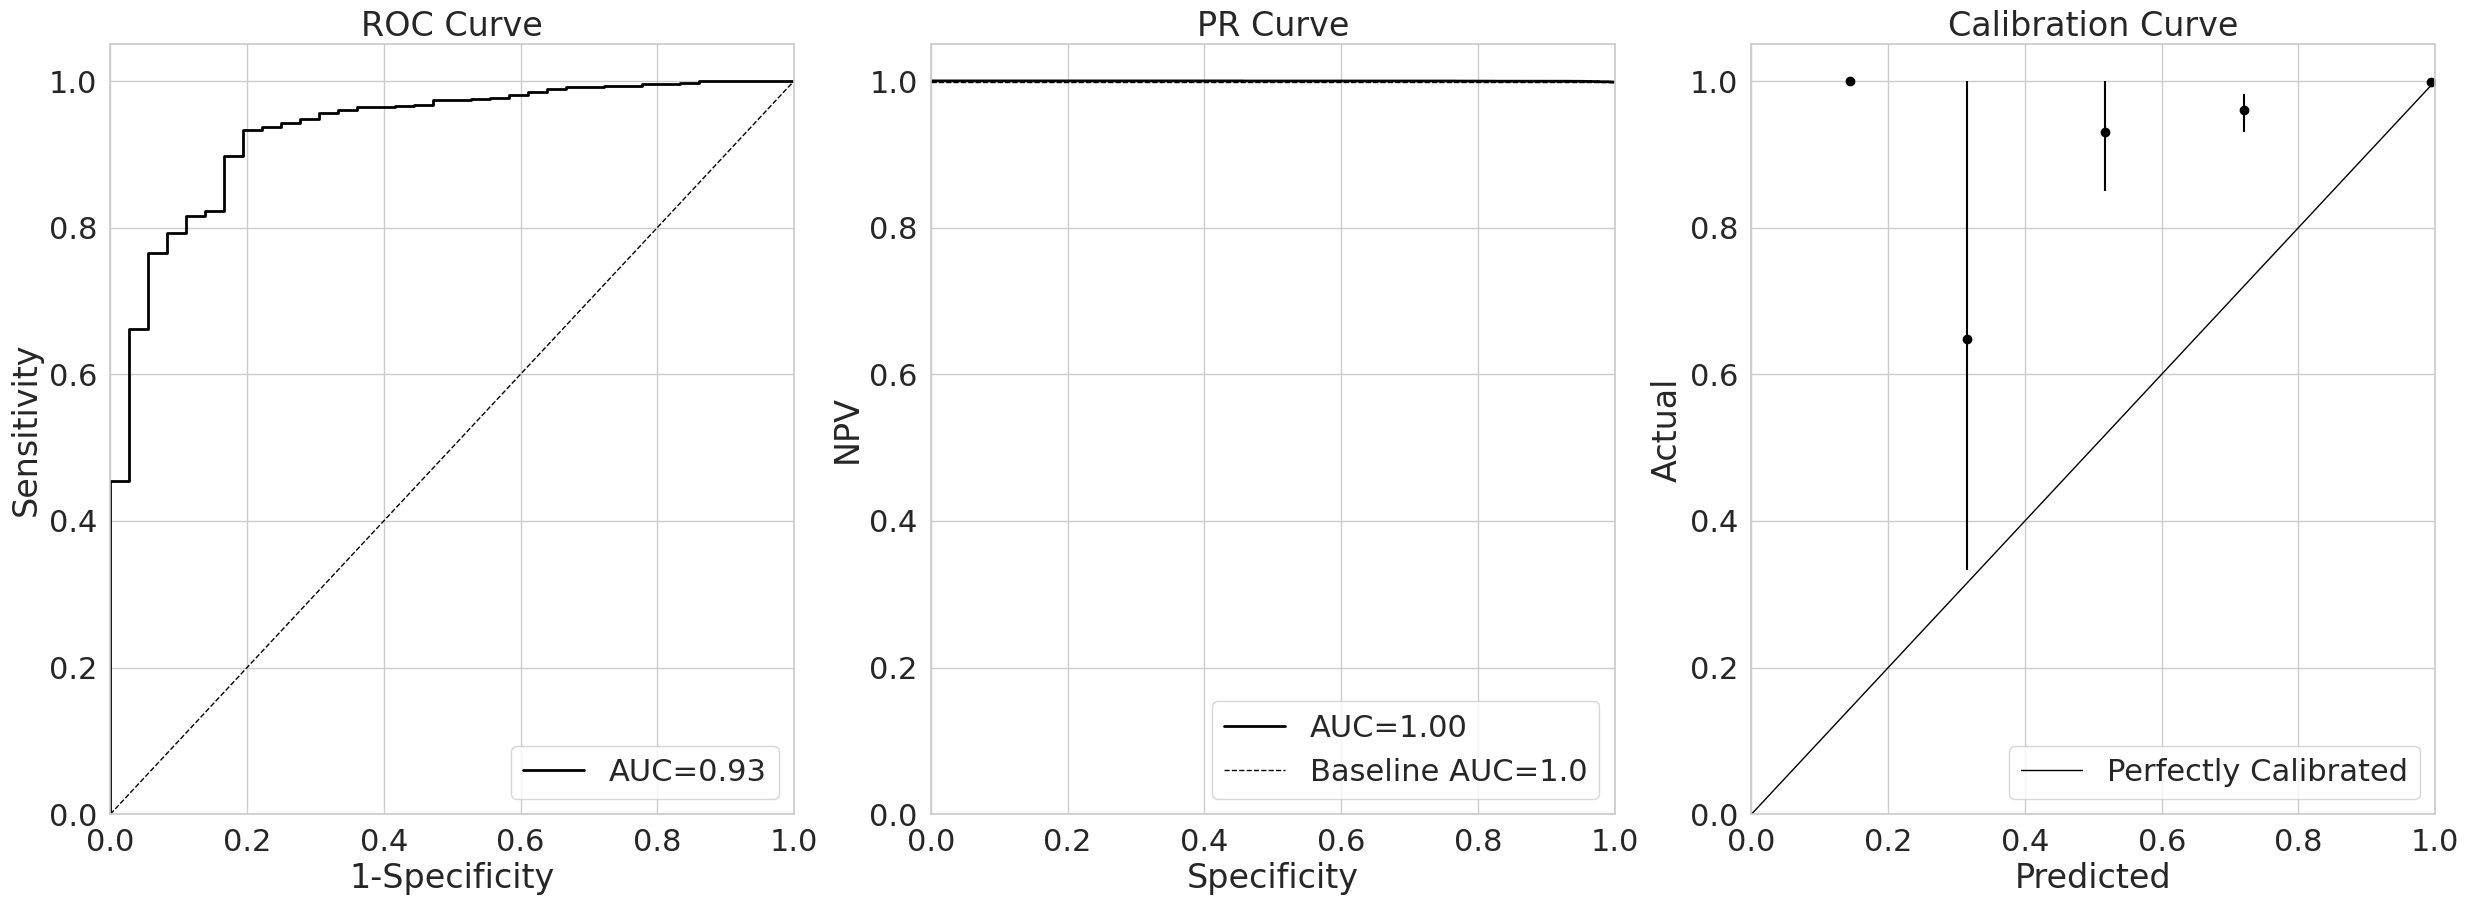

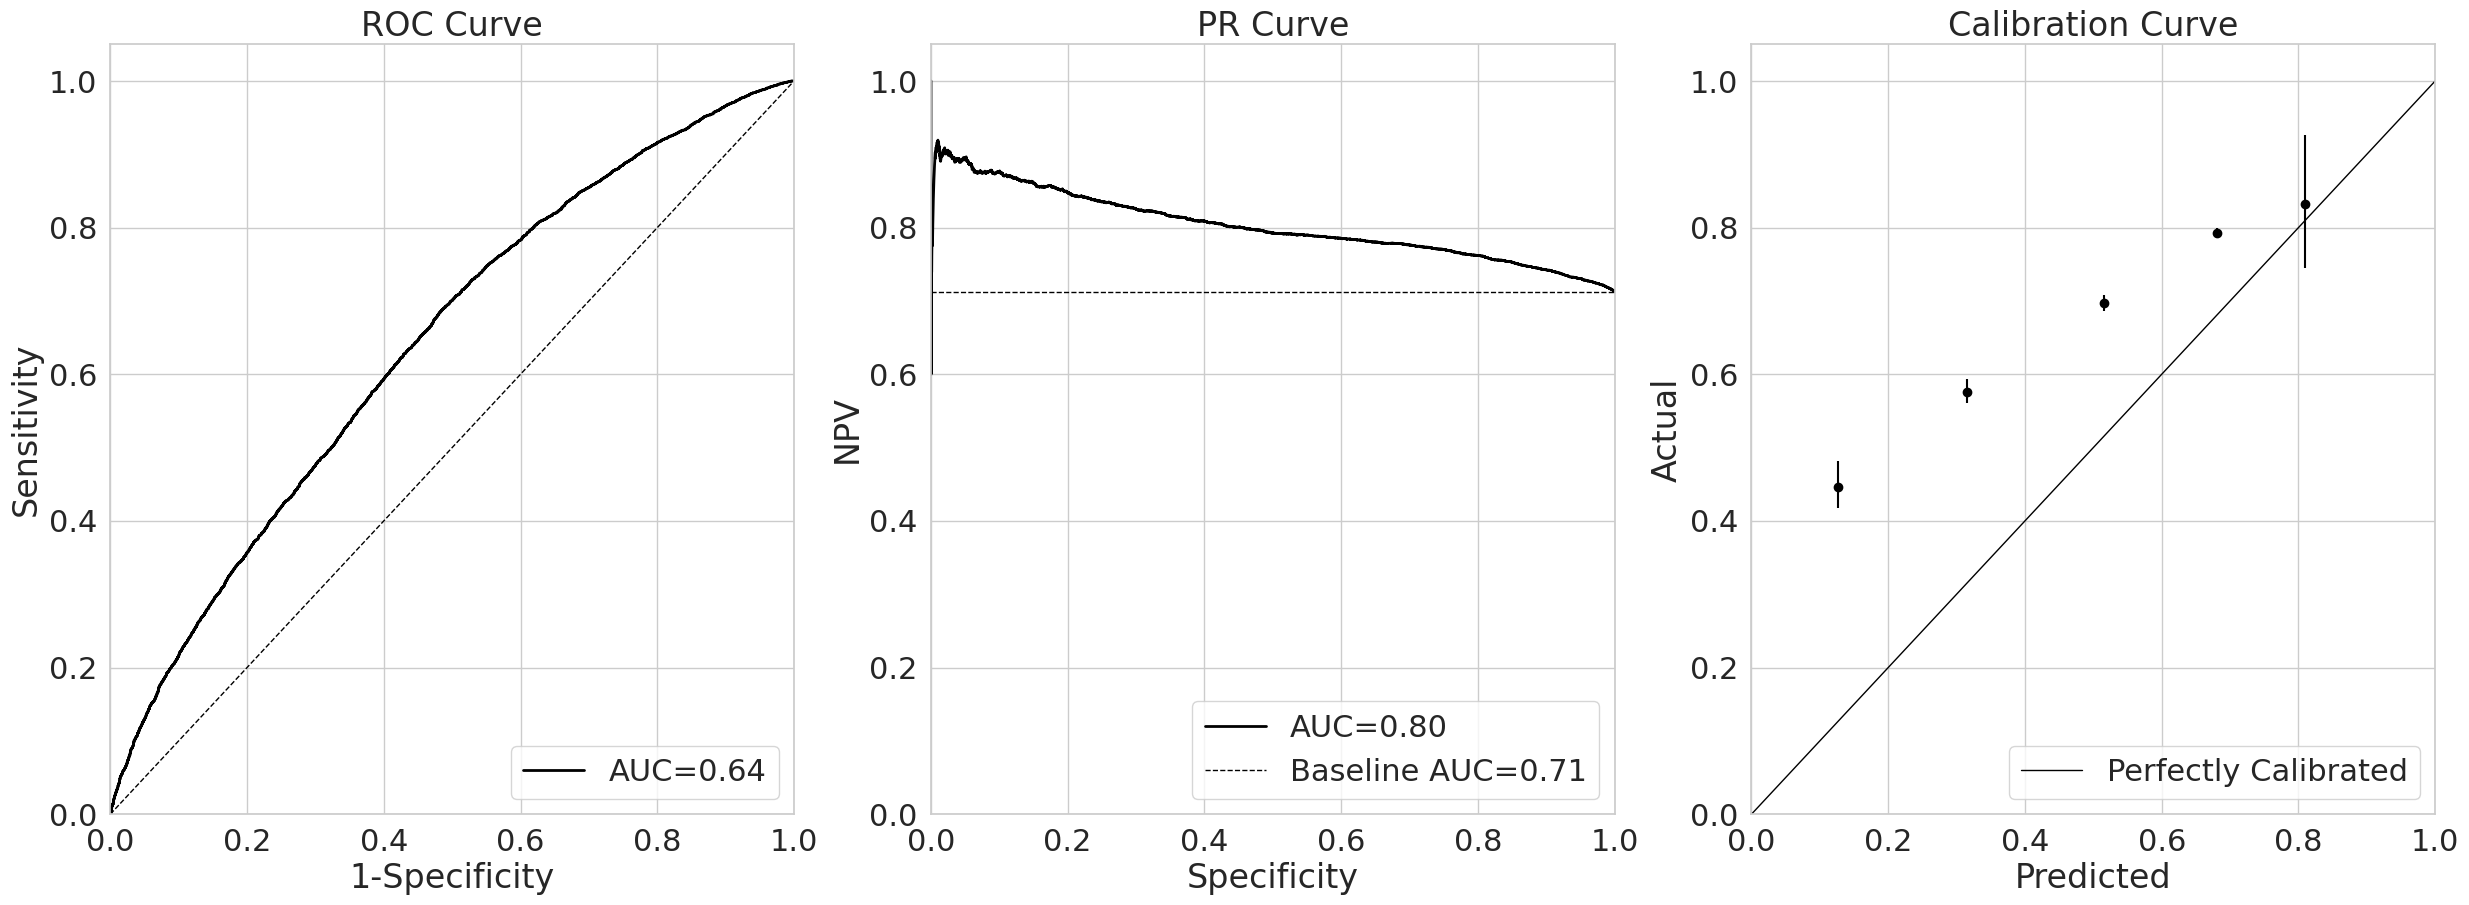

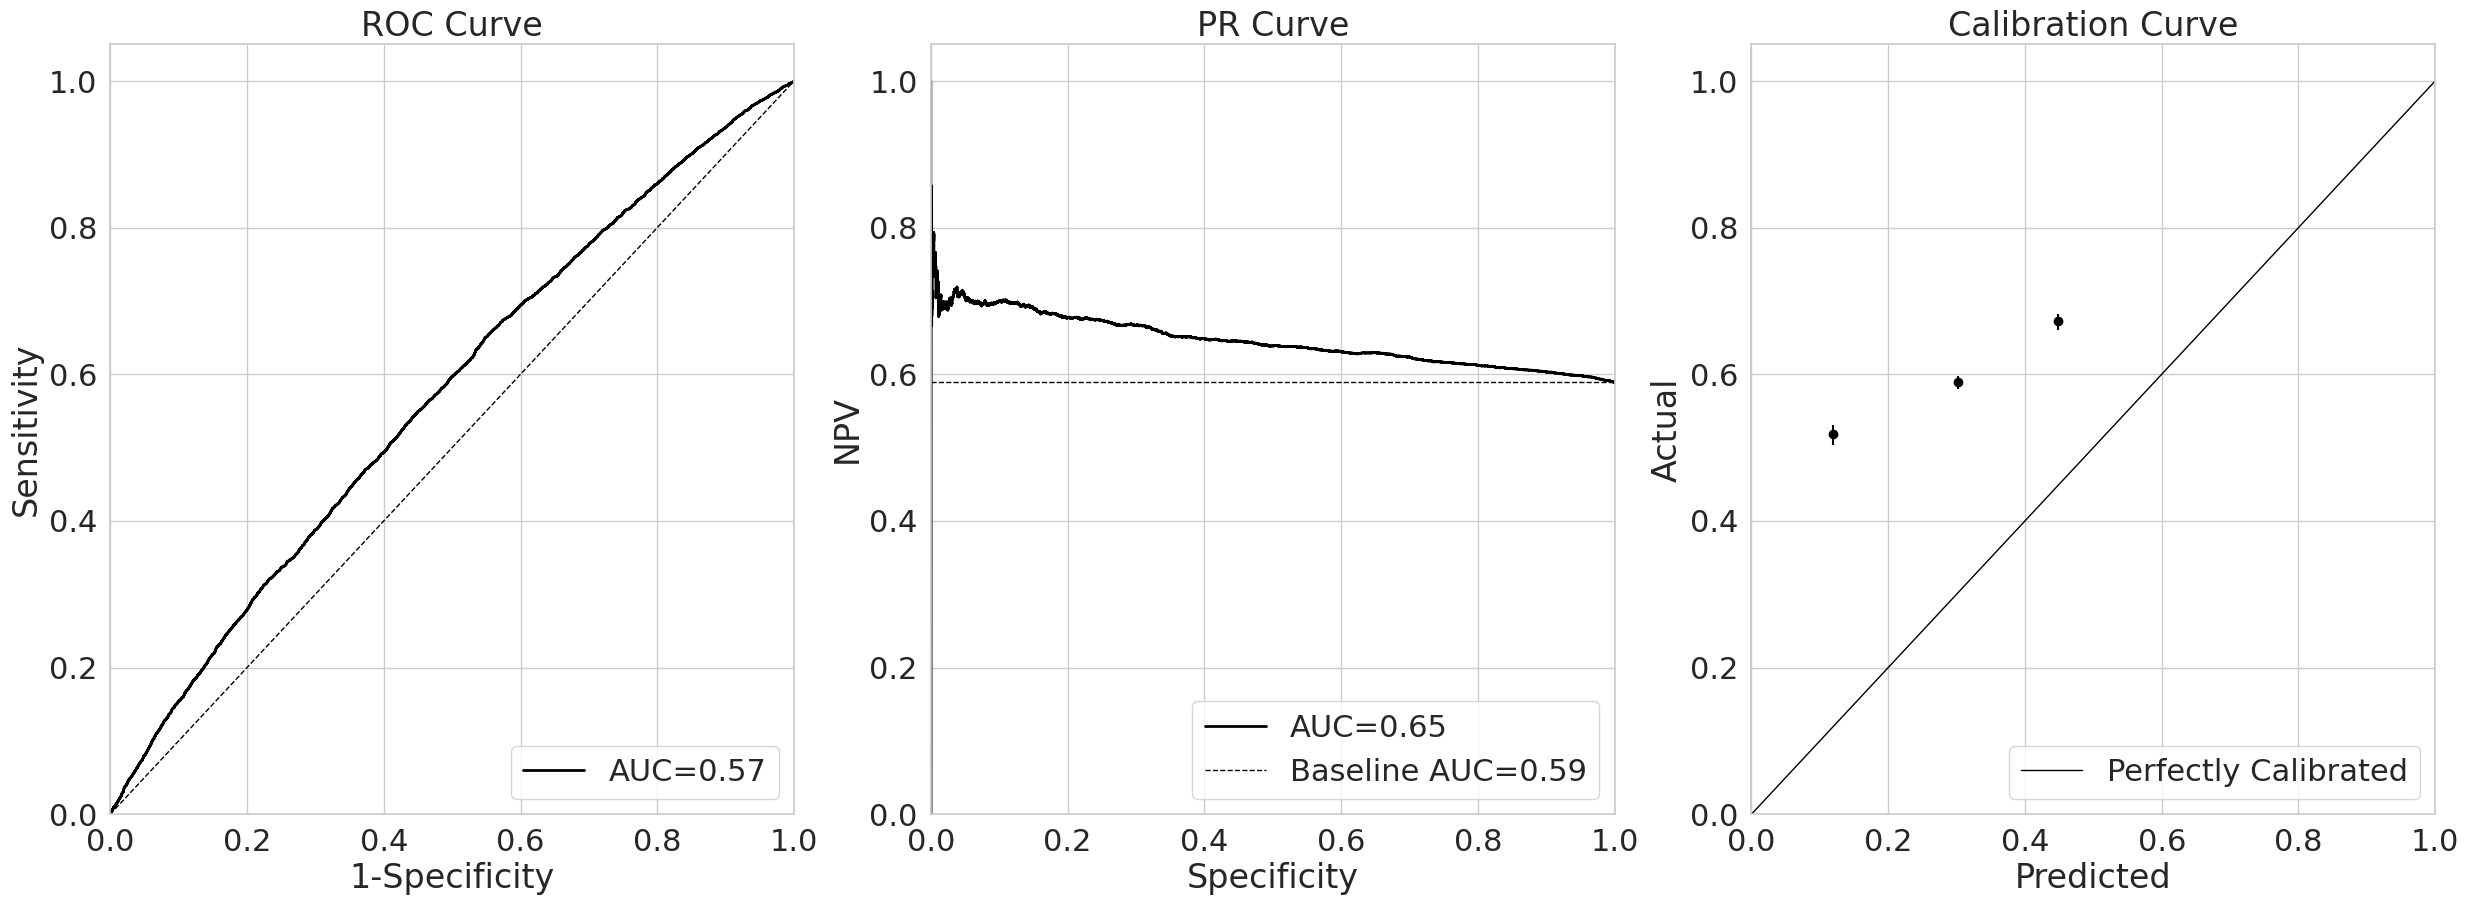

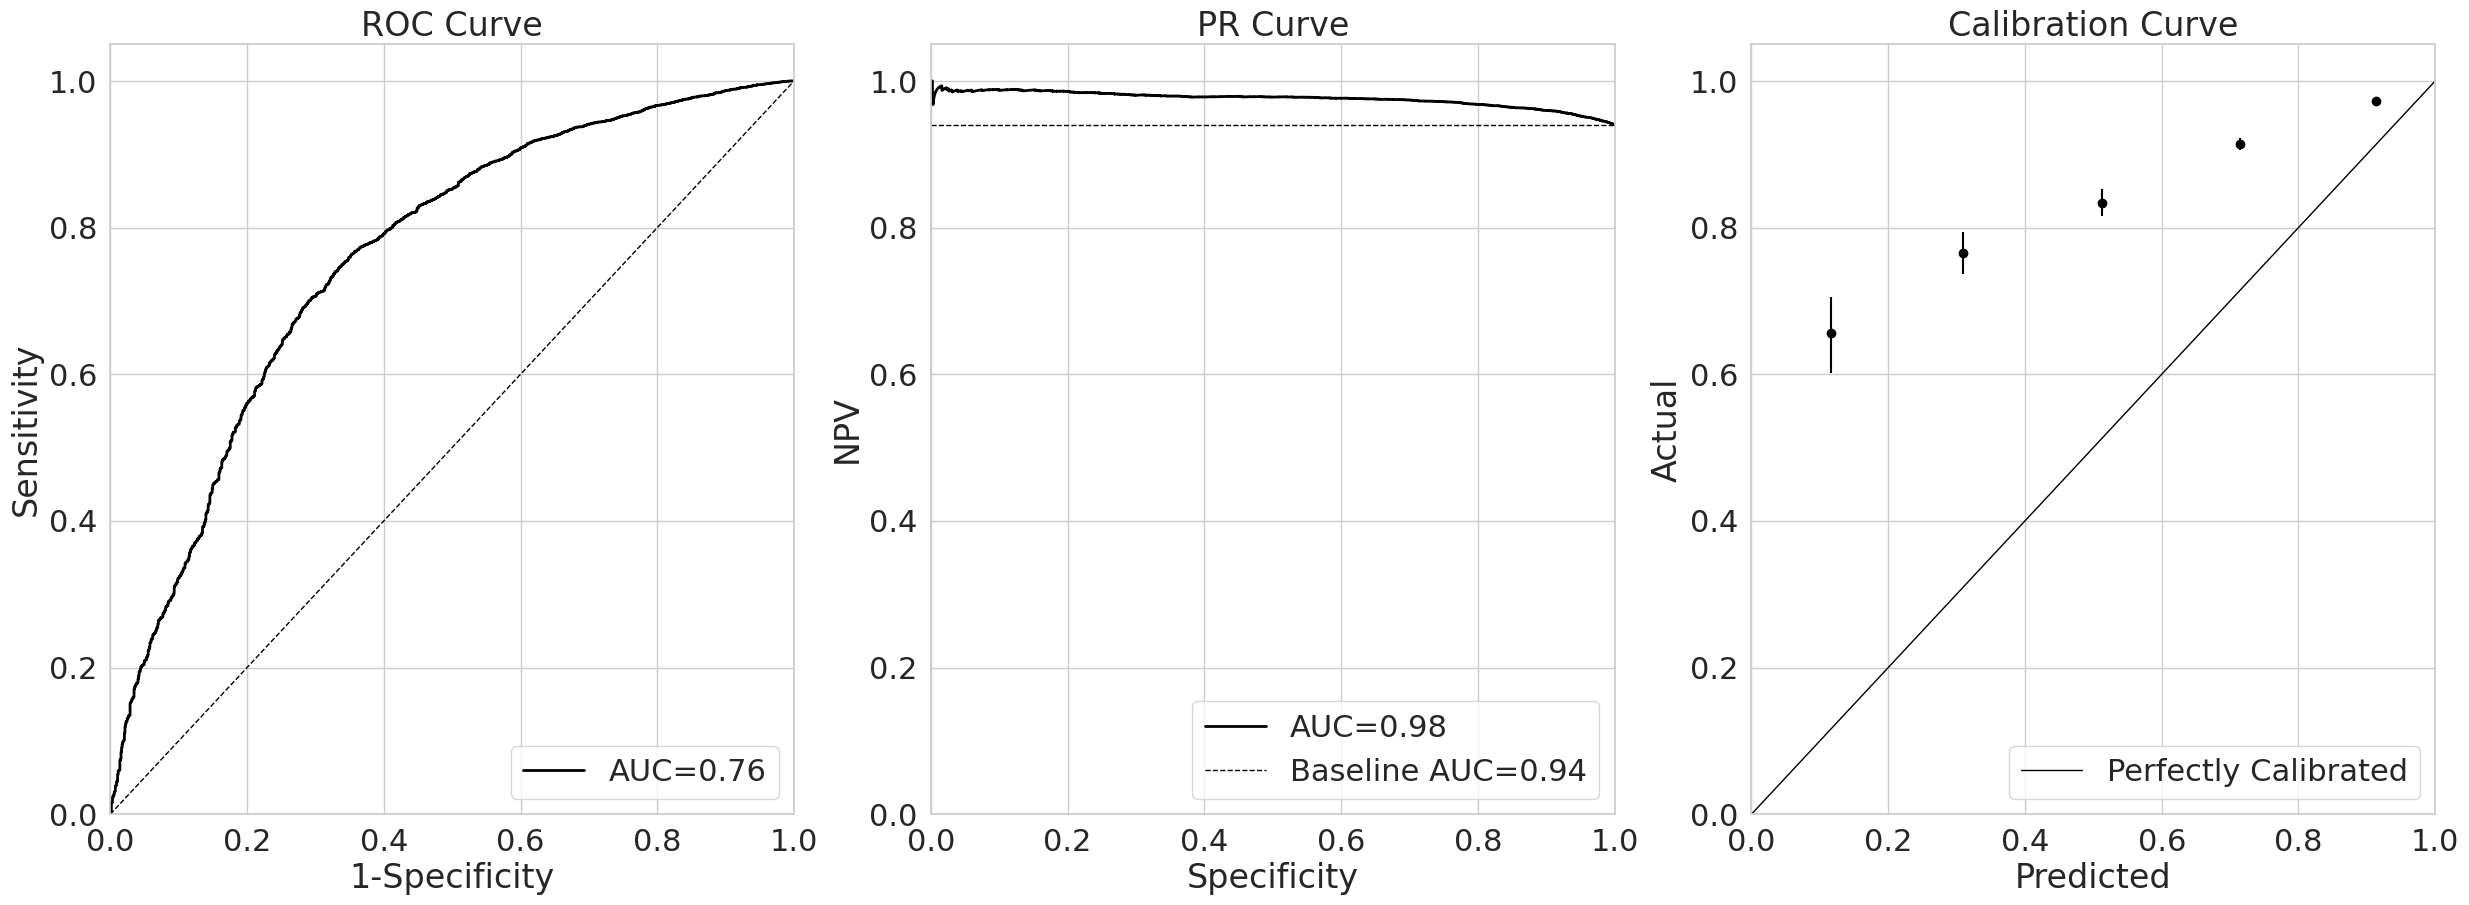

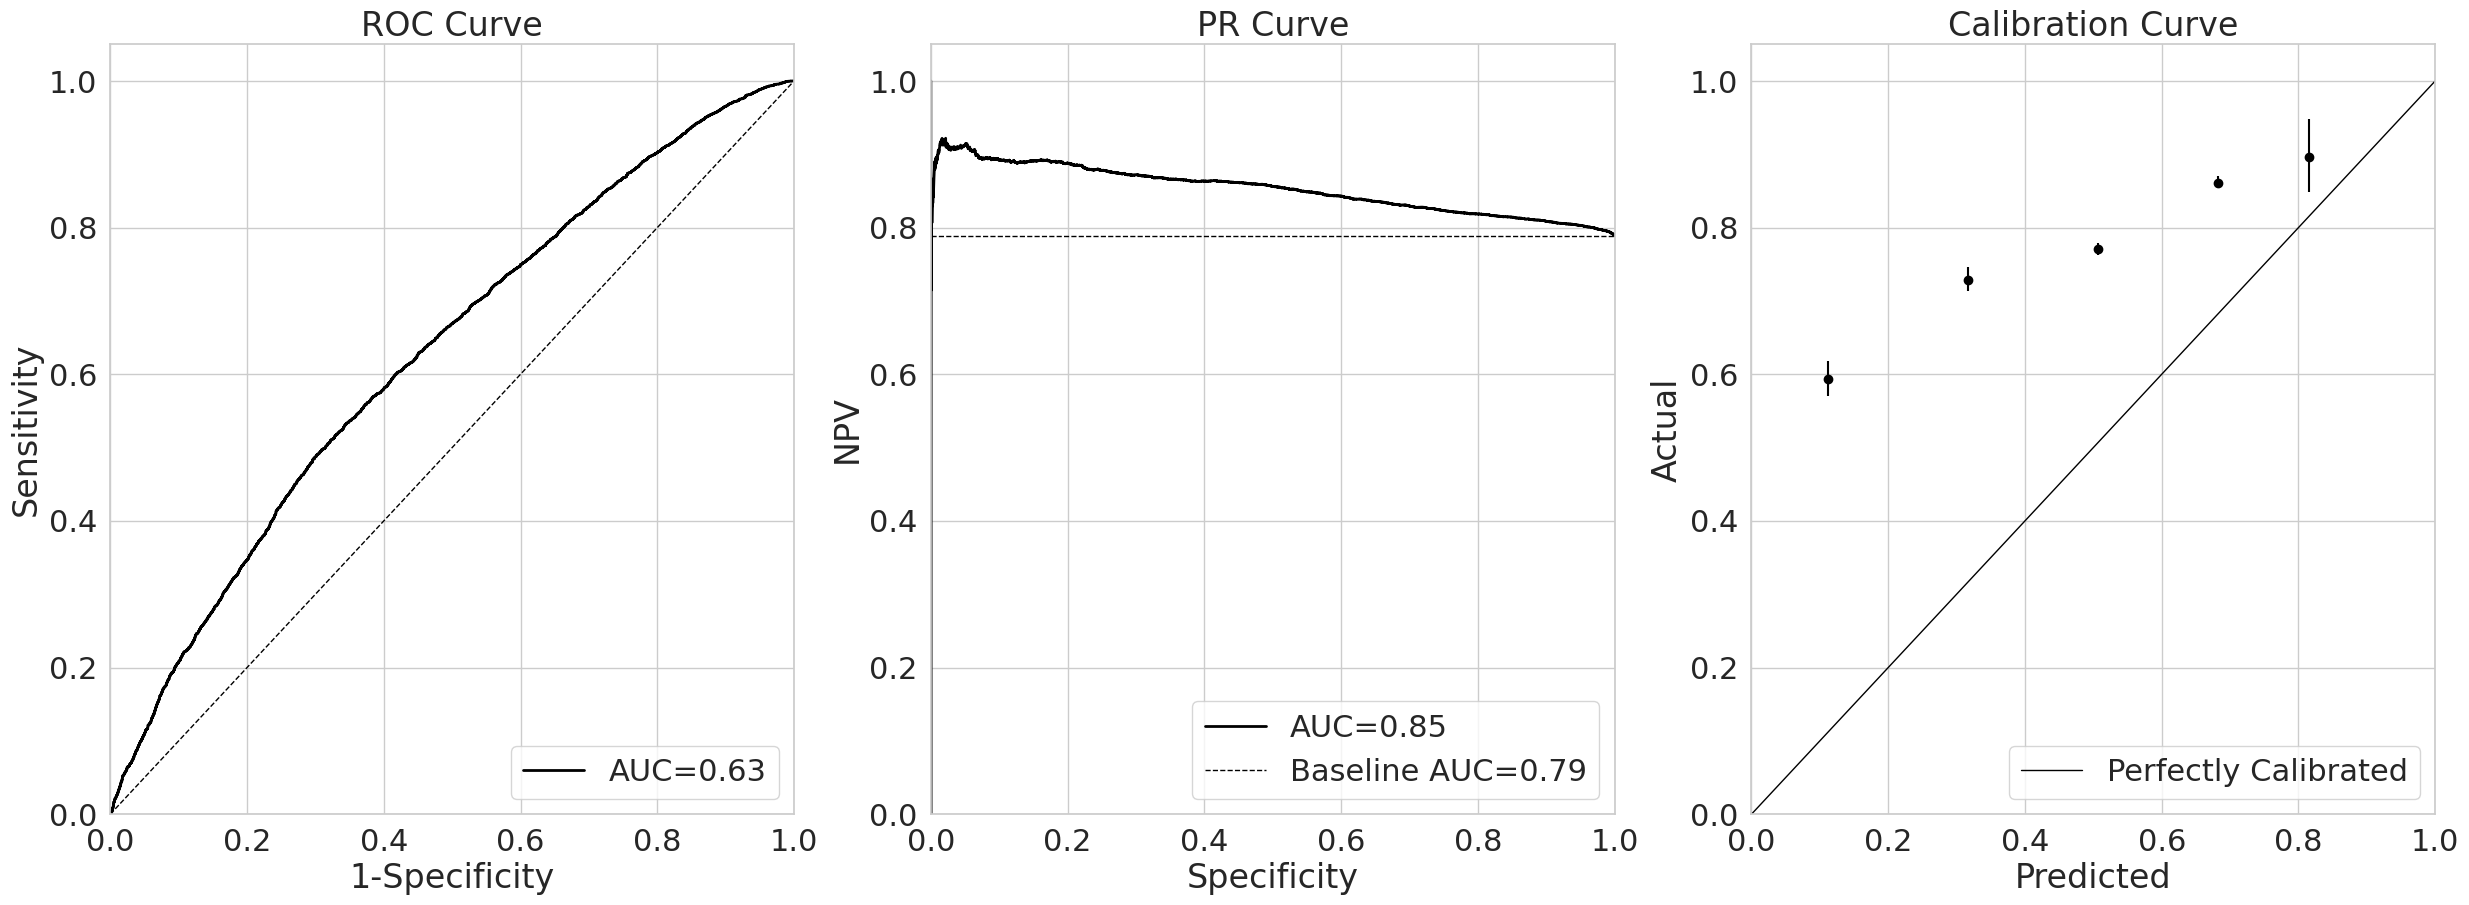

In [27]:
for task in tqdm(tasks):
    evalr = BinaryEvaluator(
        outdir="/deep/group/aihc/win23/EHR/20230207_baseline_jyx_mcp_withlast_artifacts",
        task_name=task
    )
    key = task + "_stable"
    pred = None
    if task == "label_NA":
        pred = py_hats_NA["stable_p"]
    elif task == "label_K":
        pred = py_hats_K["stable_p"]
    elif task == "label_CR":
        pred = py_hats_CR["stable_p"]
    elif task == "label_CA":
        pred = py_hats_CA["stable_p"]
    elif task == "label_ALB":
        pred = py_hats_ALB["stable_p"]
    evalr(y_test[key], pred)